# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.

In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c journey-springfield

 96%|██████████████████████████████████████▌ | 502M/521M [00:05<00:00, 95.9MB/s]
100%|█████████████████████████████████████████| 521M/521M [00:05<00:00, 105MB/s]


In [2]:
import zipfile
with zipfile.ZipFile('/kaggle/working/journey-springfield.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/journey-springfield/')

In [3]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
import PIL
print(PIL.__version__)

9.5.0


In [5]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Feb 28 09:38:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              26W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [6]:
import pickle
import numpy as np
import pandas as pd
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [7]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [128]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, data_augmentation=False):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        
        self.data_augmentation = data_augmentation

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        base_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(RESCALE_SIZE),
            transforms.RandomHorizontalFlip(),
            base_transform
        ])
        
        test_transform = transforms.Compose([
            transforms.Resize(RESCALE_SIZE),
            transforms.CenterCrop(RESCALE_SIZE),
            base_transform
        ])
        
        transform = {
            'train': train_transform,
            'test': test_transform,
            'val': test_transform
        }
            
        x = self.load_sample(self.files[index])
        if self.data_augmentation:
            x = transform[self.mode](x)
        else:
            x = test_transform(x)
            
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/working/journey-springfield/train')
TEST_DIR = Path('/kaggle/working/journey-springfield/testset')

In [11]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [16]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

In [17]:
len(train_files), len(val_files)

(16746, 4187)

In [18]:
pd.DataFrame(train_val_labels).value_counts().sort_values()

0                       
lionel_hutz                    3
disco_stu                      8
troy_mcclure                   8
miss_hoover                   17
fat_tony                      27
gil                           27
otto_mann                     32
sideshow_mel                  40
agnes_skinner                 42
rainier_wolfcastle            45
cletus_spuckler               47
snake_jailbird                55
professor_john_frink          65
martin_prince                 71
patty_bouvier                 72
ralph_wiggum                  89
carl_carlson                  98
selma_bouvier                103
barney_gumble                106
groundskeeper_willie         121
maggie_simpson               128
waylon_smithers              181
mayor_quimby                 246
lenny_leonard                310
nelson_muntz                 358
edna_krabappel               457
comic_book_guy               469
kent_brockman                498
apu_nahasapeemapetilon       623
sideshow_bob      

In [19]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

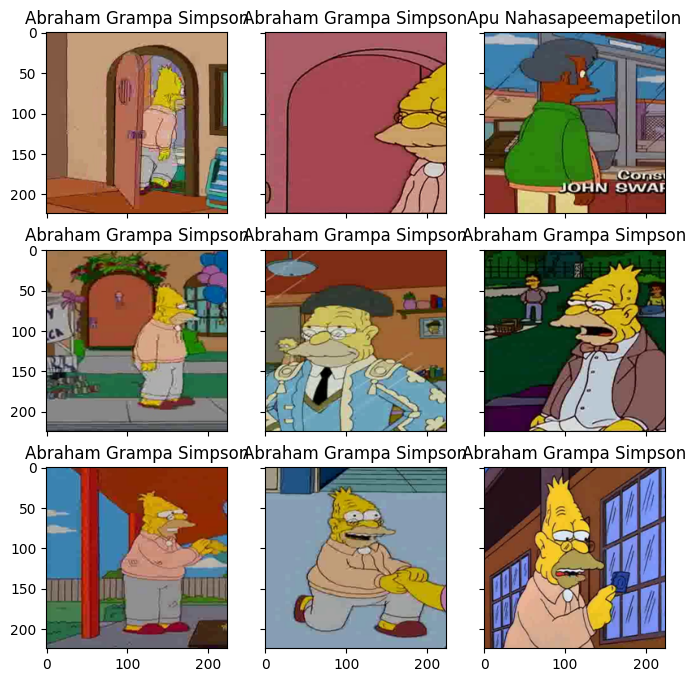

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5

In [21]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [22]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [23]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [58]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [25]:
def train(
    train_files,
    val_files,
    model,
    criterion,
    optimizer,
    scheduler,
    epochs,
    batch_size
):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, scheduler)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [26]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [40]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = F.softmax(logit, dim=-1).numpy()
    return probs

### SimpleCnn

In [27]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
params = count_parameters(simple_cnn)
print("we will classify: {}".format(n_classes))
print("we have parameters: {}\n".format(params))
print(simple_cnn)

we will classify: 42
we have parameters: 180762

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Line

In [28]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn.parameters(), lr=1e-3)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

In [33]:
history = train(
    train_files=train_dataset,
    val_files=val_dataset,
    model=simple_cnn,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=exp_lr_scheduler,
    epochs=20,
    batch_size=32
)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 2.353357578141137


epoch:   5%|▌         | 1/20 [00:59<18:51, 59.53s/it]


Epoch 001 train_loss: 2.3534     val_loss 1.6150 train_acc 0.3492 val_acc 0.5634
loss 1.2096029224645475


epoch:  10%|█         | 2/20 [01:58<17:41, 58.95s/it]


Epoch 002 train_loss: 1.2096     val_loss 1.0760 train_acc 0.6736 val_acc 0.7165
loss 0.7754851422770596


epoch:  15%|█▌        | 3/20 [02:56<16:39, 58.80s/it]


Epoch 003 train_loss: 0.7755     val_loss 0.8936 train_acc 0.7851 val_acc 0.7686
loss 0.5427058767947789


epoch:  20%|██        | 4/20 [03:55<15:39, 58.72s/it]


Epoch 004 train_loss: 0.5427     val_loss 0.8494 train_acc 0.8478 val_acc 0.7807
loss 0.40055822968041616


epoch:  25%|██▌       | 5/20 [04:56<14:55, 59.69s/it]


Epoch 005 train_loss: 0.4006     val_loss 0.8574 train_acc 0.8837 val_acc 0.7965
loss 0.3035336756275914


epoch:  30%|███       | 6/20 [05:55<13:52, 59.47s/it]


Epoch 006 train_loss: 0.3035     val_loss 0.8909 train_acc 0.9120 val_acc 0.8008
loss 0.14561852184077018


epoch:  35%|███▌      | 7/20 [06:55<12:53, 59.49s/it]


Epoch 007 train_loss: 0.1456     val_loss 0.9891 train_acc 0.9587 val_acc 0.8247
loss 0.0951799241690016


epoch:  40%|████      | 8/20 [07:55<11:56, 59.69s/it]


Epoch 008 train_loss: 0.0952     val_loss 1.0888 train_acc 0.9740 val_acc 0.8187
loss 0.07920664094569121


epoch:  45%|████▌     | 9/20 [08:55<10:59, 59.95s/it]


Epoch 009 train_loss: 0.0792     val_loss 1.2960 train_acc 0.9767 val_acc 0.8089
loss 0.06411264832116549


epoch:  50%|█████     | 10/20 [09:55<09:57, 59.73s/it]


Epoch 010 train_loss: 0.0641     val_loss 1.2905 train_acc 0.9806 val_acc 0.8159
loss 0.05508145844161414


epoch:  55%|█████▌    | 11/20 [10:54<08:56, 59.62s/it]


Epoch 011 train_loss: 0.0551     val_loss 1.3840 train_acc 0.9831 val_acc 0.8206
loss 0.04749923221716673


epoch:  60%|██████    | 12/20 [11:53<07:54, 59.33s/it]


Epoch 012 train_loss: 0.0475     val_loss 1.4321 train_acc 0.9847 val_acc 0.8139
loss 0.017329178981232273


epoch:  65%|██████▌   | 13/20 [12:51<06:53, 59.04s/it]


Epoch 013 train_loss: 0.0173     val_loss 1.4915 train_acc 0.9961 val_acc 0.8266
loss 0.008299231982543728


epoch:  70%|███████   | 14/20 [13:50<05:53, 58.94s/it]


Epoch 014 train_loss: 0.0083     val_loss 1.5875 train_acc 0.9988 val_acc 0.8268
loss 0.003485403759153222


epoch:  75%|███████▌  | 15/20 [14:49<04:54, 58.87s/it]


Epoch 015 train_loss: 0.0035     val_loss 1.6884 train_acc 0.9996 val_acc 0.8273
loss 0.0032791059111699434


epoch:  80%|████████  | 16/20 [15:47<03:54, 58.75s/it]


Epoch 016 train_loss: 0.0033     val_loss 1.7617 train_acc 0.9996 val_acc 0.8271
loss 0.004888881548088242


epoch:  85%|████████▌ | 17/20 [16:46<02:56, 58.81s/it]


Epoch 017 train_loss: 0.0049     val_loss 1.9775 train_acc 0.9990 val_acc 0.8056
loss 0.030121758166553166


epoch:  90%|█████████ | 18/20 [17:45<01:57, 58.88s/it]


Epoch 018 train_loss: 0.0301     val_loss 1.7711 train_acc 0.9910 val_acc 0.8245
loss 0.003841562585518506


epoch:  95%|█████████▌| 19/20 [18:43<00:58, 58.78s/it]


Epoch 019 train_loss: 0.0038     val_loss 1.7682 train_acc 0.9996 val_acc 0.8285
loss 0.001559898722772591


epoch: 100%|██████████| 20/20 [19:43<00:00, 59.15s/it]


Epoch 020 train_loss: 0.0016     val_loss 1.8463 train_acc 0.9999 val_acc 0.8266


In [72]:
def plot_history(param, history):
    train_loss, train_acc, val_loss, val_acc = zip(*history)
    
#     val_acc = [val.cpu().numpy() for val in val_acc]
    history_map = {
        "accuracy": (train_acc, val_acc),
        "loss": (train_loss, val_loss)
    }
    
    plt.figure(figsize=(15, 9))
    plt.plot(history_map[param][0], label='train')
    plt.plot(history_map[param][1], label='val')
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel(param)
    plt.title(f"{param} history")
    plt.grid()
    plt.show()

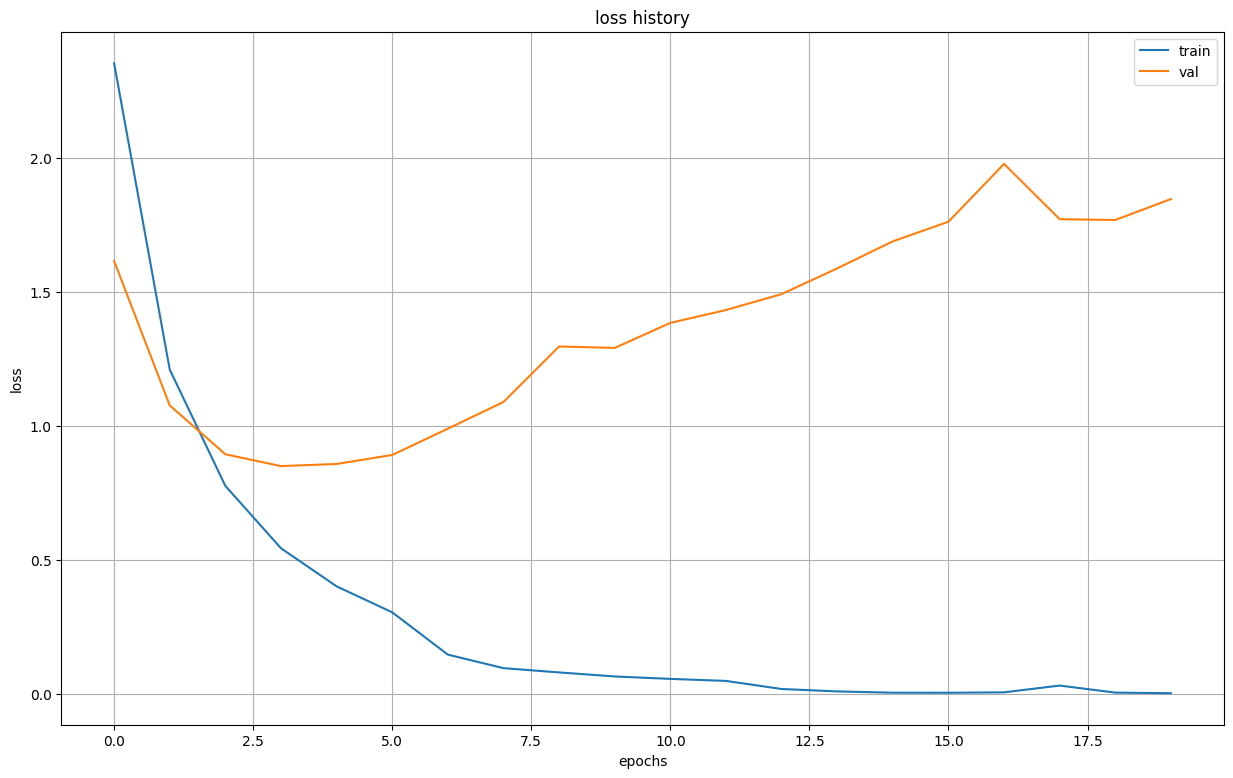

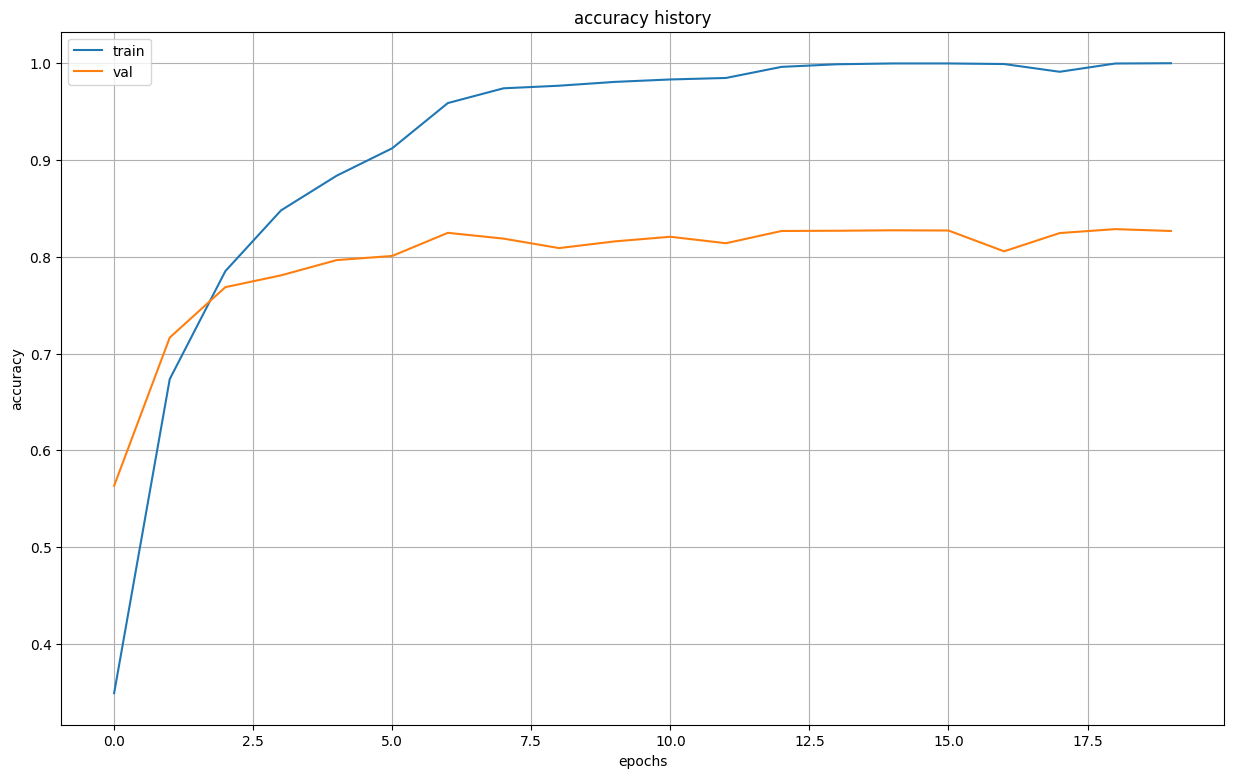

In [71]:
plot_history("loss", history)
plot_history("accuracy", history)

In [73]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [78]:
def evaluate_f1(val_dataset, model_cnn):
    idxs = list(map(int, np.random.uniform(0,1000, 500)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
    probs_ims = predict(model_cnn, imgs)
    
    y_pred = np.argmax(probs_ims,-1)
    actual_labels = [val_dataset[id][1] for id in idxs]
    preds_class = [label_encoder.classes_[i] for i in y_pred]
    
    f1 = f1_score(actual_labels, y_pred, average='micro')
    return f1

In [80]:
f1 = evaluate_f1(val_dataset, simple_cnn)
print(f'F1 = {f1}')

F1 = 0.792


### SimpleCnn with data augmentation

In [118]:
simple_cnn = SimpleCnn(n_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn.parameters(), lr=1e-3)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

In [119]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val', data_augmentation=True)

train_dataset = SimpsonsDataset(train_files, mode='train', data_augmentation=True)

In [120]:
history_augm = train(
    train_files=train_dataset,
    val_files=val_dataset,
    model=simple_cnn,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=exp_lr_scheduler,
    epochs=20,
    batch_size=32
)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 2.999369045518624


epoch:   5%|▌         | 1/20 [00:48<15:24, 48.66s/it]


Epoch 001 train_loss: 2.9994     val_loss 2.6940 train_acc 0.1440 val_acc 0.2520
loss 2.578040087335528


epoch:  10%|█         | 2/20 [01:37<14:40, 48.93s/it]


Epoch 002 train_loss: 2.5780     val_loss 1.9213 train_acc 0.2869 val_acc 0.4836
loss 2.065016936646501


epoch:  15%|█▌        | 3/20 [02:26<13:48, 48.73s/it]


Epoch 003 train_loss: 2.0650     val_loss 1.5165 train_acc 0.4420 val_acc 0.6004
loss 1.7627922636938966


epoch:  20%|██        | 4/20 [03:15<13:04, 49.03s/it]


Epoch 004 train_loss: 1.7628     val_loss 1.2004 train_acc 0.5286 val_acc 0.6824
loss 1.5857547240118877


epoch:  25%|██▌       | 5/20 [04:05<12:17, 49.18s/it]


Epoch 005 train_loss: 1.5858     val_loss 1.0764 train_acc 0.5714 val_acc 0.7091
loss 1.4701819858371066


epoch:  30%|███       | 6/20 [04:54<11:27, 49.13s/it]


Epoch 006 train_loss: 1.4702     val_loss 0.9432 train_acc 0.6034 val_acc 0.7430
loss 1.3382041189073448


epoch:  35%|███▌      | 7/20 [05:42<10:36, 48.92s/it]


Epoch 007 train_loss: 1.3382     val_loss 0.8842 train_acc 0.6439 val_acc 0.7679
loss 1.2970521350666058


epoch:  40%|████      | 8/20 [06:32<09:50, 49.17s/it]


Epoch 008 train_loss: 1.2971     val_loss 0.8357 train_acc 0.6563 val_acc 0.7839
loss 1.2545151048473713


epoch:  45%|████▌     | 9/20 [07:21<09:01, 49.26s/it]


Epoch 009 train_loss: 1.2545     val_loss 0.7886 train_acc 0.6624 val_acc 0.7920
loss 1.2141416544813446


epoch:  50%|█████     | 10/20 [08:10<08:11, 49.19s/it]


Epoch 010 train_loss: 1.2141     val_loss 0.8070 train_acc 0.6747 val_acc 0.7882
loss 1.1949154541695486


epoch:  55%|█████▌    | 11/20 [09:00<07:22, 49.17s/it]


Epoch 011 train_loss: 1.1949     val_loss 0.8082 train_acc 0.6760 val_acc 0.7925
loss 1.164241807059007


epoch:  60%|██████    | 12/20 [09:49<06:33, 49.21s/it]


Epoch 012 train_loss: 1.1642     val_loss 0.7742 train_acc 0.6834 val_acc 0.8001
loss 1.1139958294135872


epoch:  65%|██████▌   | 13/20 [10:39<05:45, 49.40s/it]


Epoch 013 train_loss: 1.1140     val_loss 0.7210 train_acc 0.7019 val_acc 0.8130
loss 1.0997881282262871


epoch:  70%|███████   | 14/20 [11:28<04:56, 49.42s/it]


Epoch 014 train_loss: 1.0998     val_loss 0.7176 train_acc 0.7044 val_acc 0.8142
loss 1.0694185717692728


epoch:  75%|███████▌  | 15/20 [12:18<04:07, 49.42s/it]


Epoch 015 train_loss: 1.0694     val_loss 0.7196 train_acc 0.7121 val_acc 0.8137
loss 1.0655784558241874


epoch:  80%|████████  | 16/20 [13:07<03:17, 49.39s/it]


Epoch 016 train_loss: 1.0656     val_loss 0.6793 train_acc 0.7159 val_acc 0.8297
loss 1.0628436004960322


epoch:  85%|████████▌ | 17/20 [13:56<02:27, 49.29s/it]


Epoch 017 train_loss: 1.0628     val_loss 0.6895 train_acc 0.7143 val_acc 0.8237
loss 1.0494223569977972


epoch:  90%|█████████ | 18/20 [14:46<01:38, 49.37s/it]


Epoch 018 train_loss: 1.0494     val_loss 0.6778 train_acc 0.7167 val_acc 0.8290
loss 1.0112194225065714


epoch:  95%|█████████▌| 19/20 [15:35<00:49, 49.27s/it]


Epoch 019 train_loss: 1.0112     val_loss 0.6660 train_acc 0.7268 val_acc 0.8326
loss 1.0103988738010452


epoch: 100%|██████████| 20/20 [16:24<00:00, 49.23s/it]


Epoch 020 train_loss: 1.0104     val_loss 0.6683 train_acc 0.7327 val_acc 0.8357


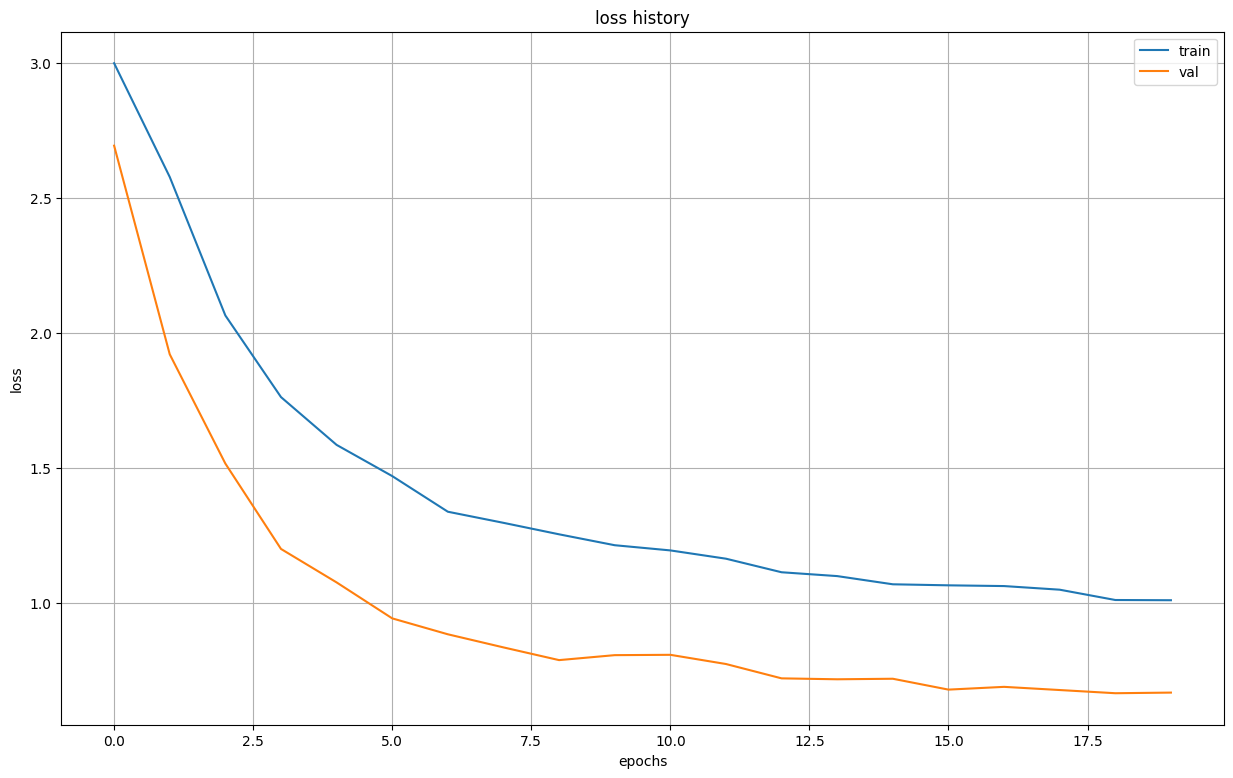

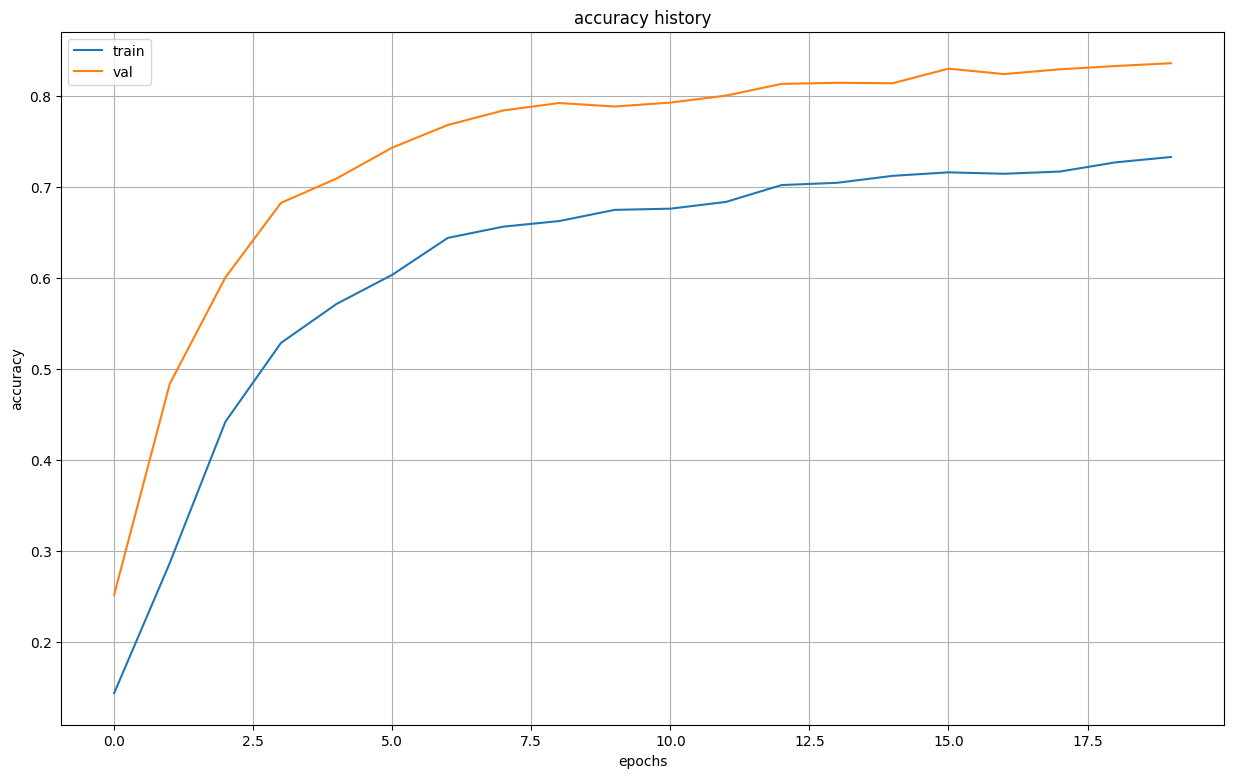

In [121]:
plot_history("loss", history_augm)
plot_history("accuracy", history_augm)

In [122]:
f1 = evaluate_f1(val_dataset, simple_cnn)
print(f'F1 = {f1}')

F1 = 0.816


### ResNet as feature extractor

In [134]:
model_resnet50 = models.resnet50(weights='IMAGENET1K_V1')

for param in model_resnet50.parameters():
    param.require_grad = False

num_features = model_resnet50.fc.in_features
model_resnet50.fc = torch.nn.Linear(num_features, n_classes)
model_resnet50 = model_resnet50.to(DEVICE)

optimizer = torch.optim.Adam(model_resnet50.fc.parameters(), lr=1e-3)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [125]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train', data_augmentation=True)

In [126]:
history_resnet = train(
    train_files=train_dataset,
    val_files=val_dataset,
    model=model_resnet50,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=exp_lr_scheduler,
    epochs=20,
    batch_size=32
)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 2.1601488501399446


epoch:   5%|▌         | 1/20 [01:43<32:44, 103.39s/it]


Epoch 001 train_loss: 2.1601     val_loss 1.5830 train_acc 0.4344 val_acc 0.5811
loss 1.5821532436016852


epoch:  10%|█         | 2/20 [03:24<30:35, 101.99s/it]


Epoch 002 train_loss: 1.5822     val_loss 1.3766 train_acc 0.5761 val_acc 0.6346
loss 1.458121215700605


epoch:  15%|█▌        | 3/20 [05:05<28:48, 101.65s/it]


Epoch 003 train_loss: 1.4581     val_loss 1.4174 train_acc 0.6073 val_acc 0.5935
loss 1.3825236062315591


epoch:  20%|██        | 4/20 [06:47<27:05, 101.61s/it]


Epoch 004 train_loss: 1.3825     val_loss 1.1850 train_acc 0.6243 val_acc 0.6773
loss 1.327100595258462


epoch:  25%|██▌       | 5/20 [08:28<25:21, 101.41s/it]


Epoch 005 train_loss: 1.3271     val_loss 1.1922 train_acc 0.6387 val_acc 0.6716
loss 1.2968273603914744


epoch:  30%|███       | 6/20 [10:09<23:40, 101.47s/it]


Epoch 006 train_loss: 1.2968     val_loss 1.0944 train_acc 0.6473 val_acc 0.7005
loss 1.2634816734391872


epoch:  35%|███▌      | 7/20 [11:51<21:59, 101.48s/it]


Epoch 007 train_loss: 1.2635     val_loss 1.1885 train_acc 0.6572 val_acc 0.6690
loss 1.1428915341951422


epoch:  40%|████      | 8/20 [13:33<20:18, 101.58s/it]


Epoch 008 train_loss: 1.1429     val_loss 1.0286 train_acc 0.6882 val_acc 0.7144
loss 1.1319837439918723


epoch:  45%|████▌     | 9/20 [15:14<18:38, 101.66s/it]


Epoch 009 train_loss: 1.1320     val_loss 1.0194 train_acc 0.6909 val_acc 0.7177
loss 1.1320993521372136


epoch:  50%|█████     | 10/20 [16:56<16:55, 101.56s/it]


Epoch 010 train_loss: 1.1321     val_loss 1.0233 train_acc 0.6891 val_acc 0.7148
loss 1.1239994184227382


epoch:  55%|█████▌    | 11/20 [18:38<15:15, 101.67s/it]


Epoch 011 train_loss: 1.1240     val_loss 1.0158 train_acc 0.6902 val_acc 0.7198
loss 1.1281589573605377


epoch:  60%|██████    | 12/20 [20:19<13:32, 101.60s/it]


Epoch 012 train_loss: 1.1282     val_loss 1.0093 train_acc 0.6943 val_acc 0.7234
loss 1.1191940135345313


epoch:  65%|██████▌   | 13/20 [22:01<11:51, 101.69s/it]


Epoch 013 train_loss: 1.1192     val_loss 1.0183 train_acc 0.6956 val_acc 0.7153
loss 1.1052602508312113


epoch:  70%|███████   | 14/20 [23:42<10:09, 101.53s/it]


Epoch 014 train_loss: 1.1053     val_loss 1.0229 train_acc 0.6972 val_acc 0.7132
loss 1.1058189389555597


epoch:  75%|███████▌  | 15/20 [25:23<08:27, 101.44s/it]


Epoch 015 train_loss: 1.1058     val_loss 1.0003 train_acc 0.6972 val_acc 0.7234
loss 1.1008229263222062


epoch:  80%|████████  | 16/20 [27:05<06:45, 101.40s/it]


Epoch 016 train_loss: 1.1008     val_loss 1.0033 train_acc 0.6986 val_acc 0.7241
loss 1.0948276033285314


epoch:  85%|████████▌ | 17/20 [28:46<05:04, 101.37s/it]


Epoch 017 train_loss: 1.0948     val_loss 1.0018 train_acc 0.7018 val_acc 0.7249
loss 1.1027751469091034


epoch:  90%|█████████ | 18/20 [30:27<03:22, 101.37s/it]


Epoch 018 train_loss: 1.1028     val_loss 0.9974 train_acc 0.7017 val_acc 0.7246
loss 1.0740866706204162


epoch:  95%|█████████▌| 19/20 [32:09<01:41, 101.32s/it]


Epoch 019 train_loss: 1.0741     val_loss 1.0000 train_acc 0.7051 val_acc 0.7275
loss 1.0892979178849507


epoch: 100%|██████████| 20/20 [33:50<00:00, 101.52s/it]


Epoch 020 train_loss: 1.0893     val_loss 0.9979 train_acc 0.6991 val_acc 0.7258


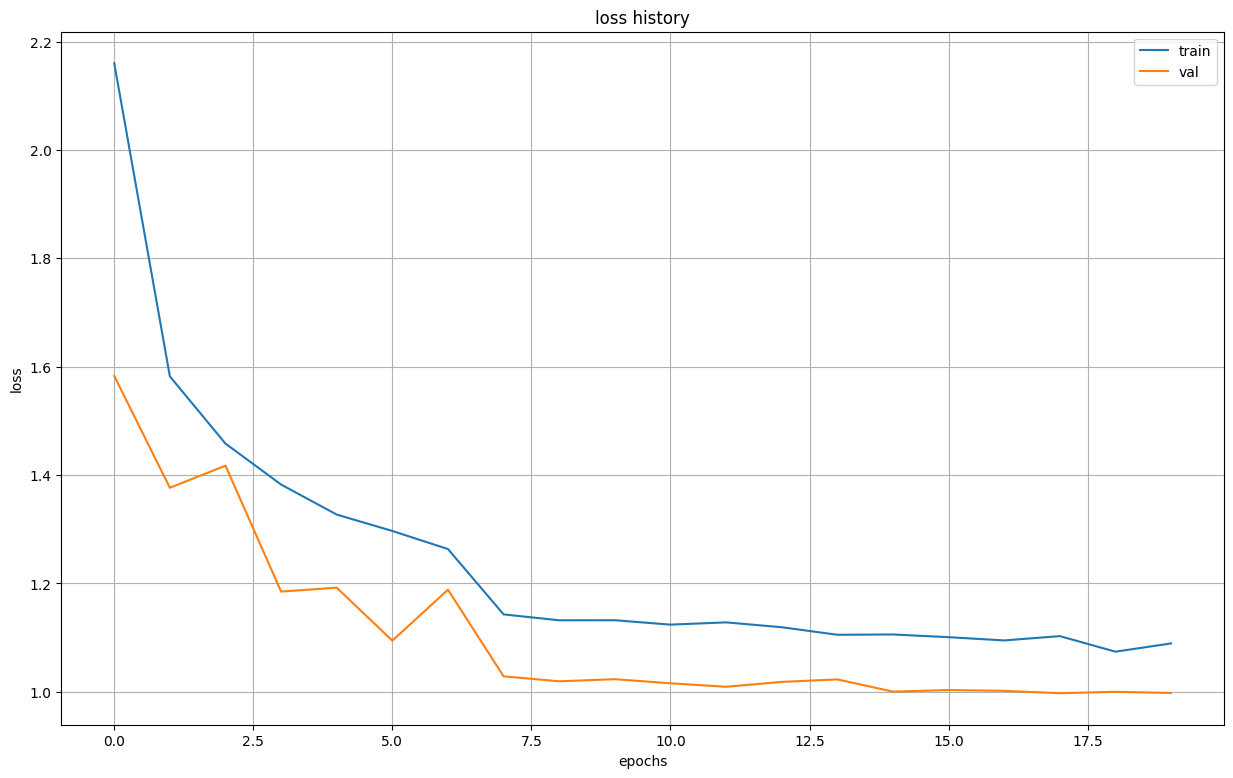

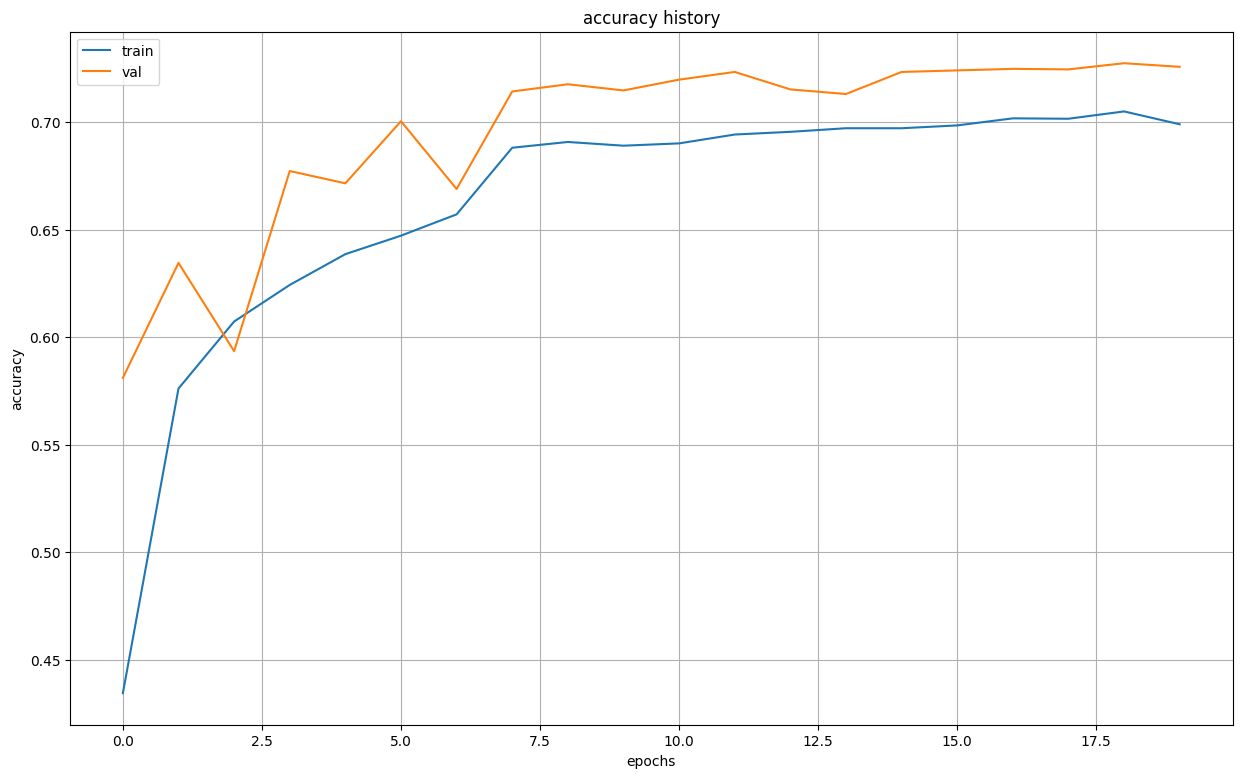

In [127]:
plot_history("loss", history_resnet)
plot_history("accuracy", history_resnet)

### ResNet with few freezed layers

In [139]:
model_resnet50_tuned = models.resnet50(weights='IMAGENET1K_V1')
layers_to_unfreeze = 5
    
layers = list(model_resnet50_tuned.children())
for layer in layers[:-layers_to_unfreeze]:
    for param in layer.parameters():
        param.requires_grad = False

num_features = model_resnet50.fc.in_features
model_resnet50_tuned.fc = torch.nn.Linear(num_features, n_classes)
model_resnet50_tuned = model_resnet50_tuned.to(DEVICE)

In [145]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_resnet50_tuned.parameters(), lr=1e-4)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [146]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train', data_augmentation=True)

In [147]:
history_resnet_tuned = train(
    train_files=train_dataset,
    val_files=val_dataset,
    model=model_resnet50_tuned,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=exp_lr_scheduler,
    epochs=20,
    batch_size=32
)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 1.0815552645482485


epoch:   5%|▌         | 1/20 [01:26<27:19, 86.30s/it]


Epoch 001 train_loss: 1.0816     val_loss 0.3561 train_acc 0.7344 val_acc 0.9109
loss 0.8191408088212085


epoch:  10%|█         | 2/20 [02:50<25:34, 85.28s/it]


Epoch 002 train_loss: 0.8191     val_loss 0.3492 train_acc 0.7876 val_acc 0.9145
loss 0.6194275349866215


epoch:  15%|█▌        | 3/20 [04:15<24:07, 85.17s/it]


Epoch 003 train_loss: 0.6194     val_loss 0.2677 train_acc 0.8367 val_acc 0.9355
loss 0.5620905594431086


epoch:  20%|██        | 4/20 [05:40<22:38, 84.92s/it]


Epoch 004 train_loss: 0.5621     val_loss 0.2709 train_acc 0.8534 val_acc 0.9343
loss 0.5195602054851081


epoch:  25%|██▌       | 5/20 [07:05<21:13, 84.92s/it]


Epoch 005 train_loss: 0.5196     val_loss 0.2620 train_acc 0.8630 val_acc 0.9369
loss 0.4720290104032033


epoch:  30%|███       | 6/20 [08:29<19:47, 84.80s/it]


Epoch 006 train_loss: 0.4720     val_loss 0.2299 train_acc 0.8762 val_acc 0.9429
loss 0.4655777168974403


epoch:  35%|███▌      | 7/20 [09:54<18:20, 84.67s/it]


Epoch 007 train_loss: 0.4656     val_loss 0.2597 train_acc 0.8777 val_acc 0.9386
loss 0.3445345912692397


epoch:  40%|████      | 8/20 [11:18<16:55, 84.61s/it]


Epoch 008 train_loss: 0.3445     val_loss 0.1517 train_acc 0.9074 val_acc 0.9699
loss 0.32483922476059046


epoch:  45%|████▌     | 9/20 [12:43<15:32, 84.76s/it]


Epoch 009 train_loss: 0.3248     val_loss 0.1409 train_acc 0.9146 val_acc 0.9709
loss 0.29845301965450666


epoch:  50%|█████     | 10/20 [14:09<14:09, 84.90s/it]


Epoch 010 train_loss: 0.2985     val_loss 0.1387 train_acc 0.9223 val_acc 0.9718
loss 0.290767236627197


epoch:  55%|█████▌    | 11/20 [15:34<12:44, 84.95s/it]


Epoch 011 train_loss: 0.2908     val_loss 0.1330 train_acc 0.9230 val_acc 0.9728
loss 0.2841985786192864


epoch:  60%|██████    | 12/20 [16:58<11:19, 84.89s/it]


Epoch 012 train_loss: 0.2842     val_loss 0.1242 train_acc 0.9252 val_acc 0.9747
loss 0.28252024912291723


epoch:  65%|██████▌   | 13/20 [18:23<09:53, 84.82s/it]


Epoch 013 train_loss: 0.2825     val_loss 0.1296 train_acc 0.9233 val_acc 0.9756
loss 0.2824983402128311


epoch:  70%|███████   | 14/20 [19:48<08:29, 84.93s/it]


Epoch 014 train_loss: 0.2825     val_loss 0.1317 train_acc 0.9234 val_acc 0.9721
loss 0.24892906665848274


epoch:  75%|███████▌  | 15/20 [21:14<07:05, 85.05s/it]


Epoch 015 train_loss: 0.2489     val_loss 0.1231 train_acc 0.9329 val_acc 0.9752
loss 0.2615369008521456


epoch:  80%|████████  | 16/20 [22:38<05:39, 84.91s/it]


Epoch 016 train_loss: 0.2615     val_loss 0.1219 train_acc 0.9306 val_acc 0.9754
loss 0.2578063008341708


epoch:  85%|████████▌ | 17/20 [24:03<04:14, 84.77s/it]


Epoch 017 train_loss: 0.2578     val_loss 0.1212 train_acc 0.9300 val_acc 0.9754
loss 0.26339104918080763


epoch:  90%|█████████ | 18/20 [25:27<02:49, 84.77s/it]


Epoch 018 train_loss: 0.2634     val_loss 0.1218 train_acc 0.9286 val_acc 0.9761
loss 0.25464279684361046


epoch:  95%|█████████▌| 19/20 [26:52<01:24, 84.77s/it]


Epoch 019 train_loss: 0.2546     val_loss 0.1226 train_acc 0.9324 val_acc 0.9754
loss 0.26640195854864773


epoch: 100%|██████████| 20/20 [28:17<00:00, 84.88s/it]


Epoch 020 train_loss: 0.2664     val_loss 0.1211 train_acc 0.9294 val_acc 0.9754


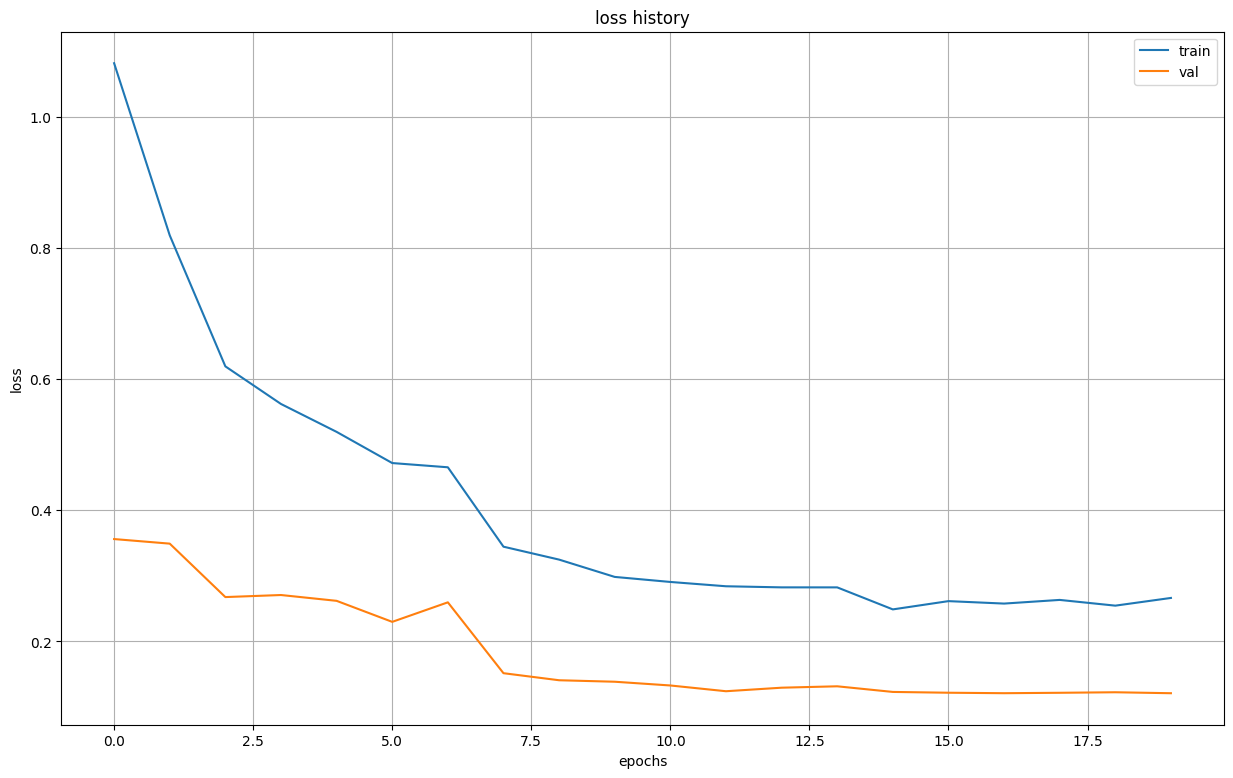

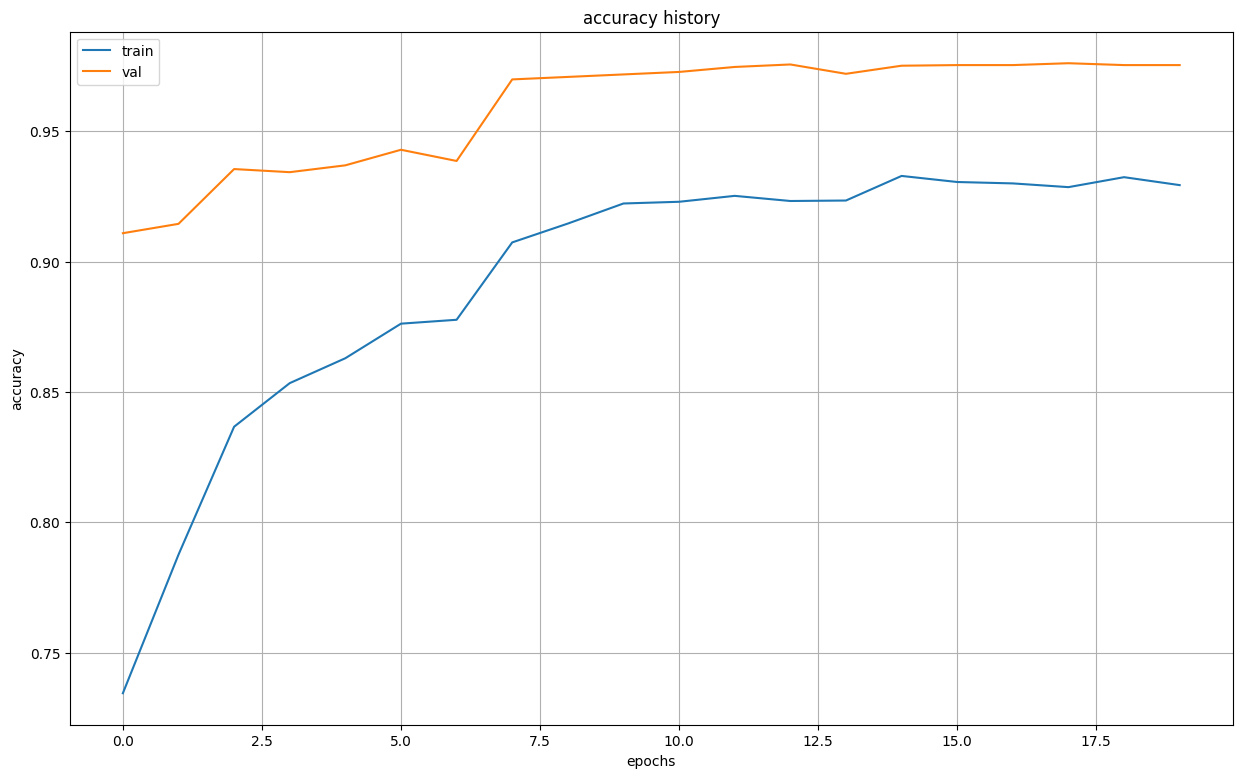

In [149]:
plot_history("loss", history_resnet_tuned)
plot_history("accuracy", history_resnet_tuned)

In [150]:
f1 = evaluate_f1(val_dataset, model_resnet50_tuned)
print(f'F1 = {f1}')

F1 = 0.976


In [2]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit the best results

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
! ls

In [ ]:
import pandas as pd
# my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)